<a href="https://colab.research.google.com/github/techcomh/genetic_program_fearure_reuse/blob/main/GP_FR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, randint, choice

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [1]:
# Funções e classes para simular programação genética simplificada
class Individual(np.ndarray):
    fitness = None

    def __new__(cls, array):
        obj = np.asarray(array).view(cls)
        obj.fitness = None
        return obj

def InitializePopulation(size, data_shape):
    return [Individual(np.random.rand(*data_shape)) for _ in range(size)]

def Evaluate(individual, X_train, y_train, X_test, y_test):
    # Simula a avaliação de um indivíduo (aqui, apenas a soma dos pesos)
    return individual.sum()

def SelectBestIndividuals(population, k=1):
    return sorted(population, key=lambda ind: ind.fitness, reverse=True)[:k]

def SelectIndividualsTournament(population, k=2):
    tournament_winners = []
    for _ in range(k):
        participants = [choice(population) for _ in range(2)]
        winner = max(participants, key=lambda ind: ind.fitness)
        tournament_winners.append(winner)
    return tournament_winners

def Crossover(parent1, parent2):
    crossover_point = randint(0, parent1.shape[0] - 1)
    child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return child1, child2

def Mutate(individual, mutation_rate=0.19):
    for i in range(individual.shape[0]):
        if random() < mutation_rate:
            individual[i] = np.random.rand()
    return individual

# Carregar o conjunto de dados Labeled Faces in the Wild (LFW)
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Pré-processar os dados
X = lfw_people.data
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
pca = PCA(n_components=100, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Parâmetros da simulação
G = 25  # Número de gerações (proposto no artigo)
P_size = 250  # Tamanho da população (proposto no artigo)
data_shape = X_train_pca.shape[1:]

# Inicializar a população
P = InitializePopulation(P_size, data_shape)

# Configurar Stratified K-Fold = 5
skf = StratifiedKFold(n_splits=5)

# Loop evolutivo
for g in range(G):
    for ind in P:
        scores = []
        for train_index, test_index in skf.split(X_train_pca, y_train):
            X_train_fold, X_test_fold = X_train_pca[train_index], X_train_pca[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            score = Evaluate(ind, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
            scores.append(score)
        ind.fitness = np.mean(scores)

    Best_inds = SelectBestIndividuals(P, k=2)
    Selected_inds = SelectIndividualsTournament(P, k=2)
    New_inds = []
    for parent1, parent2 in zip(Best_inds, Selected_inds):
        child1_data, child2_data = Crossover(parent1, parent2)
        child1 = Individual(child1_data)
        child2 = Individual(child2_data)
        child1 = Mutate(child1)
        child2 = Mutate(child2)
        child1.fitness = Evaluate(child1, X_train_pca, y_train, X_test_pca, y_test)
        child2.fitness = Evaluate(child2, X_train_pca, y_train, X_test_pca, y_test)
        New_inds.append(child1)
        New_inds.append(child2)
    P.extend(New_inds)
    P = SelectBestIndividuals(P, P_size)

Best_individual = max(P, key=lambda ind: ind.fitness)
print("Melhor indivíduo:", Best_individual)
print("Fitness:", Best_individual.fitness)


Melhor indivíduo: [0.98466303 0.43642716 0.65367502 0.70706999 0.24360802 0.50372217
 0.67541488 0.8401669  0.70443783 0.65156795 0.80548987 0.91192073
 0.85214419 0.87619256 0.60638257 0.49548113 0.31571437 0.56565299
 0.75850068 0.88630926 0.50569999 0.05091139 0.93202717 0.94166122
 0.94099632 0.20446208 0.88635268 0.99167483 0.91659732 0.97311909
 0.0120194  0.70304059 0.43829829 0.0695257  0.12512769 0.39922901
 0.32810223 0.75908552 0.93676762 0.14763695 0.88452079 0.8605917
 0.11215251 0.82741795 0.80031094 0.5494437  0.75645322 0.18929227
 0.95083736 0.15158189 0.94982204 0.83282841 0.63368929 0.78252053
 0.87536669 0.67213453 0.47308702 0.88922918 0.68858549 0.94317233
 0.09914915 0.89931734 0.42853393 0.9199763  0.92205307 0.85314765
 0.77563426 0.5903509  0.46952417 0.47714544 0.7233472  0.46156365
 0.42704511 0.54184257 0.25503411 0.50686164 0.70973789 0.4286458
 0.58331621 0.98469885 0.58536295 0.04596676 0.29230573 0.71154858
 0.15801279 0.62682555 0.94899266 0.43270062 0

Accuracy: 0.11490683229813664


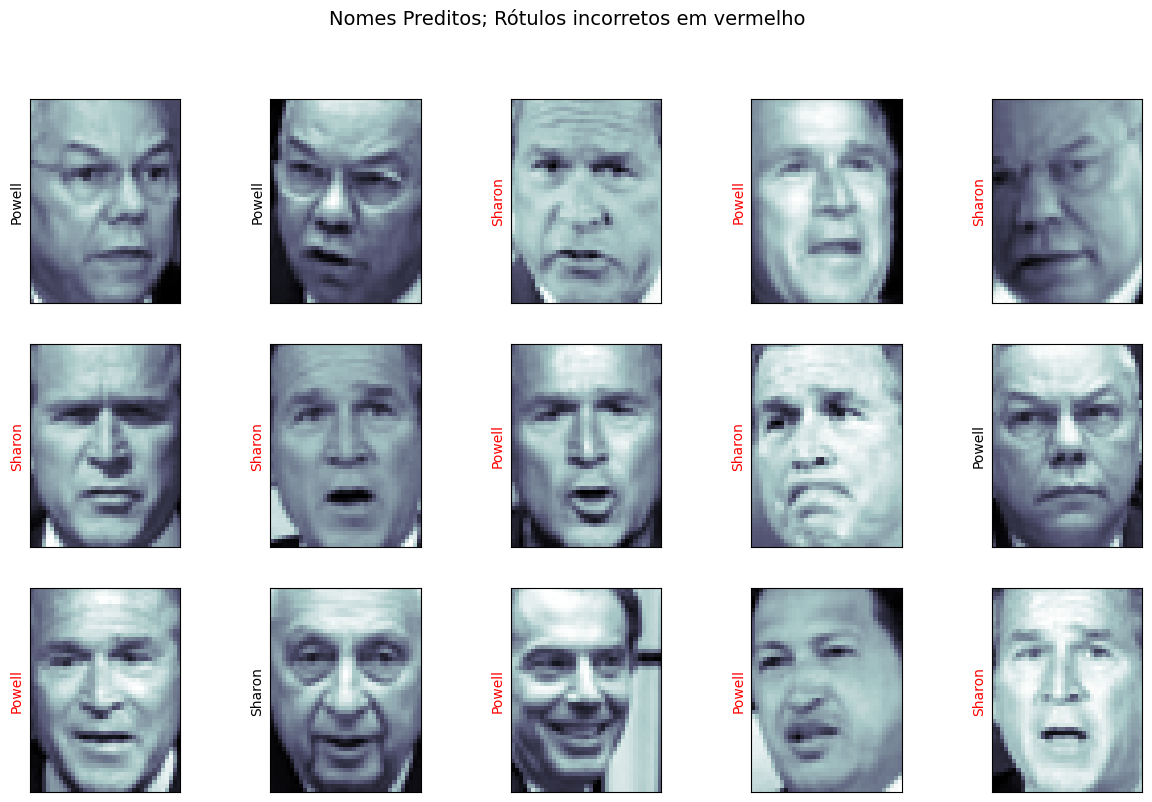

In [2]:
# Suponha que este é o melhor indivíduo (pesos do classificador) após a execução do algoritmo genético
best_individual_weights = Best_individual  # Substitua pelo seu melhor indivíduo obtido

# Carregar o conjunto de dados Labeled Faces in the Wild (LFW)
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Pré-processar os dados
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
images = lfw_people.images
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(X, y, images, test_size=0.25, stratify=y, random_state=42)

# PCA para reduzir a dimensionalidade
pca = PCA(n_components=100, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Função para fazer predições usando os pesos do melhor indivíduo
def predict(X, weights):
    # Aqui, cada "pontuação" é o produto escalar do vetor de características pelo vetor de pesos
    # Para cada amostra em X
    scores = np.dot(X, weights)

    # Se o problema é binário, a predição pode ser feita com um limiar, por exemplo, 0.5
    # Para problemas multiclasse, você teria que ter um conjunto de pesos para cada classe e usar np.argmax
    predictions = (scores > 0.5).astype(int)

    return predictions

# Fazer predições no conjunto de teste
predictions = predict(X_test_pca, best_individual_weights)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Exibir algumas imagens do conjunto de teste com as predições
fig, ax = plt.subplots(3, 5, figsize=(15, 9))
for i, axi in enumerate(ax.flat):
    axi.imshow(images_test[i].reshape(50, 37), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(target_names[predictions[i]].split()[-1],
                   color='black' if predictions[i] == y_test[i] else 'red')
fig.suptitle('Nomes Preditos; Rótulos incorretos em vermelho', size=14)
plt.show()
